In [1]:
# 导入各种库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

# 导入电影链接文件
links = pd.read_csv('datasets/ml-latest-small/links.csv')
links.head()

# 导入电影信息文件
movies = pd.read_csv('datasets/ml-latest-small/movies.csv')
movies.head()

# 导入评分文件
ratings = pd.read_csv('datasets/ml-latest-small/ratings.csv')
ratings.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [17]:
# 将电影信息和电影链接根据电影id合并
movies_add_links = pd.merge(movies, links ,on='movieId')

def get_year(x):
    try:
        y = int(x.strip()[-5:-1])
    except:
        y = 0
        
    return y
# 获取电影年份
movies_add_links['movie_year'] = movies_add_links['title'].apply(get_year)

# 计算每个电影的被评论次数
rating_counts = pd.DataFrame(ratings.groupby('movieId').count()['rating'])
rating_counts.rename(columns={'rating':'ratingCount'}, inplace=True)
rating_counts.head()
# 合并到一起
movie_add_rating = pd.merge(movies_add_links, rating_counts, on='movieId')

# 获取每个电影的平均评分并合并
rating_means = pd.DataFrame(ratings.groupby('movieId').mean()['rating'])
rating_means.columns=['rating_mean']
movie_total = pd.merge(movie_add_rating, rating_means, on='movieId')
movie_total.head()

,ratingCount
movieId,
1,215
2,110
3,52
4,7
5,49


,movieId,title,genres,imdbId,tmdbId,movie_year,ratingCount,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1995,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,1995,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,1995,52,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,1995,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,1995,49,3.071429


Text(0.5, 1.0, 'Rating Distribution\n')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

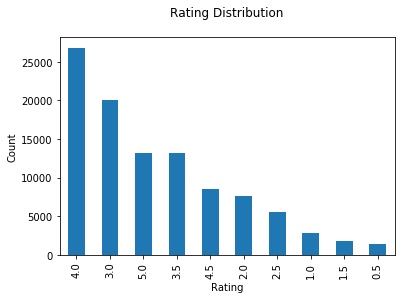

In [22]:
# 评分分布情况
ratings.rating.value_counts(sort=True).plot('bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating.png', bbox_inches='tight')
plt.show()

<Figure size 1152x1152 with 0 Axes>

Text(0.5, 1.0, 'Movies counts by years\n')

Text(0.5, 0, 'years')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'Movies ratings by years\n')

Text(0.5, 0, 'years')

Text(0, 0.5, 'ratings')

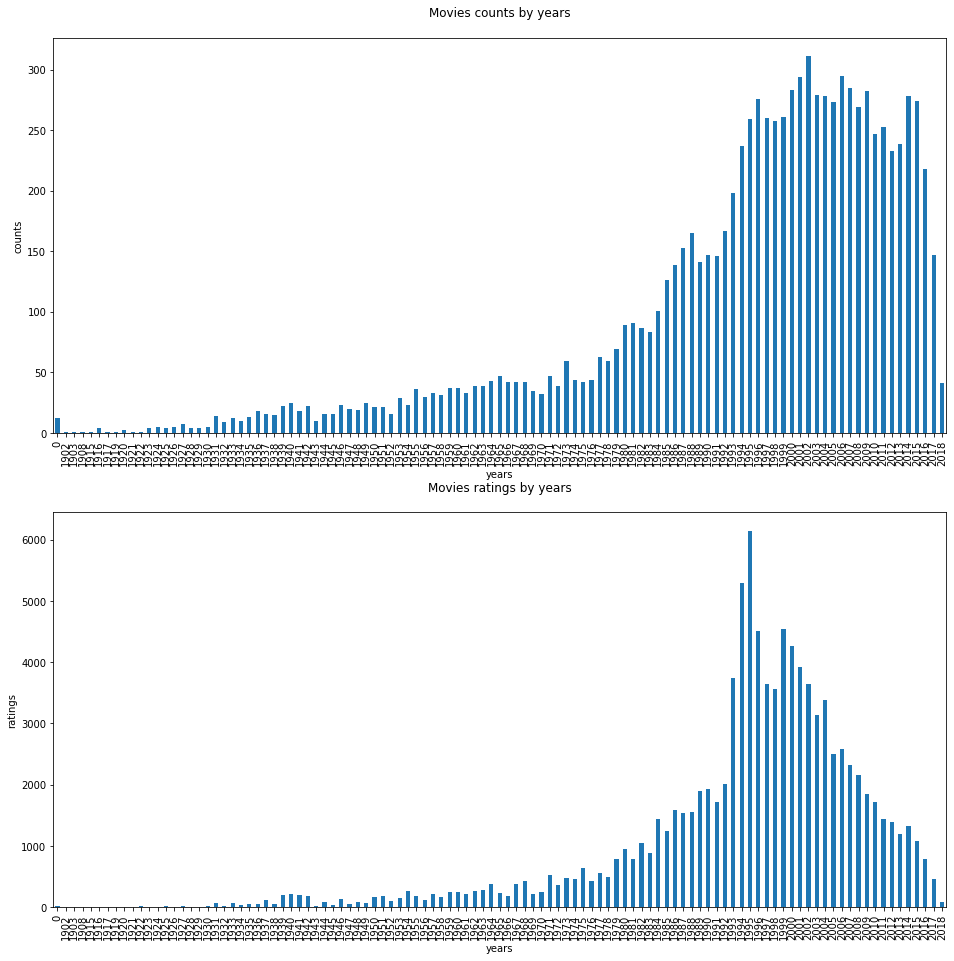

In [73]:
### 可视化每年电影数量和每年电影被评论数量 ###
# 设置画幅
plt.figure(figsize=(16,16))
# 分层
plt.subplot(2,1,1)
# 每年电影数
movie_total.groupby('movie_year')['ratingCount'].count().plot('bar')
plt.title('Movies counts by years\n')
plt.xlabel('years')
plt.ylabel('counts')
# 每年电影评论数
plt.subplot(2,1,2)
movie_total.groupby('movie_year')['ratingCount'].sum().plot('bar')
plt.title('Movies ratings by years\n')
plt.xlabel('years')
plt.ylabel('ratings')
plt.savefig('mix.png', bbox_inches='tight')
plt.show()


In [74]:
# 构建要使用与筛选的电影信息
combine_movie = pd.merge(ratings, rating_counts, on='movieId')
combine_movie = combine_movie.dropna()
combine_movie.head()

,userId,movieId,rating,timestamp,ratingCount
0,1,1,4.0,964982703,215
1,5,1,4.0,847434962,215
2,7,1,4.5,1106635946,215
3,15,1,2.5,1510577970,215
4,17,1,4.5,1305696483,215


In [75]:
# 计算70%评论数为多少用以筛选
combine_movie.ratingCount.quantile(np.arange(.5, 1, .05))

0.50     39.0
0.55     44.0
0.60     51.0
0.65     59.0
0.70     69.0
0.75     84.0
0.80    100.0
0.85    119.0
0.90    143.0
0.95    192.0
Name: ratingCount, dtype: float64

In [76]:
popularity_threshold = 69
# 根据位置进行筛选
rating_popular_movie = combine_movie.query('ratingCount >= @popularity_threshold')
rating_popular_movie.head()


,userId,movieId,rating,timestamp,ratingCount
0,1,1,4.0,964982703,215
1,5,1,4.0,847434962,215
2,7,1,4.5,1106635946,215
3,15,1,2.5,1510577970,215
4,17,1,4.5,1305696483,215


In [100]:
# 将表格转化为2D矩阵
movie_pivot = rating_popular_movie.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# 看看用户多少，电影多少
movie_pivot.shape
movie_pivot.head()
movie_pivot[6]



(264, 602)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
10,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0
11,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2.5,3.0,0.0,0.0,0.0


movieId
1         0.0
2         4.0
6         4.0
10        3.0
11        4.0
16        4.0
19        2.0
21        2.0
25        3.0
32        4.0
34        4.0
39        0.0
47        4.0
50        1.0
62        4.0
95        4.0
104       4.0
110       5.0
111       0.0
141       4.0
150       4.0
153       3.0
161       3.0
165       3.0
185       3.0
208       3.0
223       0.0
231       3.0
235       0.0
253       3.0
         ... 
8874      0.0
8961      0.0
32587     0.0
33493     0.0
33794     0.0
35836     0.0
40815     0.0
44191     0.0
45722     0.0
46578     0.0
48394     0.0
48516     0.0
48780     0.0
49272     0.0
50872     0.0
51662     0.0
54286     0.0
58559     0.0
59315     0.0
60069     0.0
63082     0.0
68157     0.0
68954     0.0
69122     0.0
72998     0.0
79132     0.0
89745     0.0
91529     0.0
99114     0.0
109487    0.0
Name: 6, Length: 264, dtype: float64

In [78]:
# 选出评分数最多的电影id
movie_1 = ratings.groupby('movieId').count().sort_values('rating', ascending=False).index[19]
movie_1
movie_total[movie_total.movieId == movie_1]



4993

,movieId,title,genres,imdbId,tmdbId,movie_year,ratingCount,rating_mean
3633,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,120737,120.0,2001,198,4.106061


In [90]:
# 获取电影详细信息函数
def get_movie(df_movie, moive_list):
    # 根据电影ID获取电影详细信息
    df_movieId = pd.DataFrame(movie_list, index=np.arange(len(movie_list)), columns=['movieId'])
    corr_movies = pd.merge(df_movieId, df_movie, on='movieId')
    return corr_movies

def pearson_method(df_movie, pivot, movie, num):
    # 获取目标电影属性

    bones_ratings = pivot[movie]
    # 计算出电影跟该电影的皮尔森相关性
    similar_to_bones = pivot.corrwith(bones_ratings)
    corr_bones = pd.DataFrame(similar_to_bones, columns=['pearson'])
    # 弃去缺失值
    corr_bones.dropna(inplace=True)
    # 相关性与评论数合并
    corr_summary = corr_bones.join(df_movie[['movieId','ratingCount']].set_index('movieId'))
    # 刷选出对应数量的高关联性电影
    movie_list = corr_summary[corr_summary['ratingCount'] >= 100].sort_values('pearson', ascending=False).index[:num].tolist()
    return movie_list

# 获取电影ID列表
movie_list = pearson_method(movie_total, movie_pivot, movie_1, 10)
movie_list
# 获取电影详细数据
corr_movies = get_movie(movie_total, movie_list)
corr_movies

KeyError: 4993

In [85]:
def knn_method(movie_pivot, movie, num):
# 压缩稀疏矩阵
    movie_pivot_matrix = csr_matrix(movie_pivot.values)
    # 我们用来计算最近邻居的算法是“brute”，我们指定“metric =cosine”，以便算法计算评级向量之间的余弦相似度。
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    # 训练模型
    model_knn.fit(movie_pivot_matrix)
    # 根据模型找到与所选电影最近6个（包含其本身）电影
    distances, indices = model_knn.kneighbors(movie_pivot.loc[[movie], :].values.reshape(1, -1), n_neighbors = num)
    # 获取电影ID列表
    movie_list = movie_pivot.iloc[indices[0],:].index
    return movie_list
    
movie_list = knn_method(movie_pivot, movie_1, 6)   
corr_movies = get_movie(movie_total, movie_list)
corr_movies


,movieId,title,genres,imdbId,tmdbId,movie_year,ratingCount,rating_mean
0,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,120737,120.0,2001,198,4.106061
1,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,167260,122.0,2003,185,4.118919
2,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,167261,121.0,2002,188,4.021277
3,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,325980,22.0,2003,149,3.778523
4,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,133093,603.0,1999,278,4.192446
5,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,126029,808.0,2001,170,3.867647


In [86]:
def SVD_method(movie_pivot, movie, num):
    # 使用SVD对信息进行矩阵分解
    SVD = TruncatedSVD(n_components=12, random_state=17)
    matrix = SVD.fit_transform(movie_pivot.values)
    # 构建后信息df
    movie_SVD = pd.DataFrame(matrix, index=movie_pivot.index).T
    # 求电影之间皮尔森相关度
    corr = movie_SVD.corr()
	# 根据提供的电影查找相近的5个电影
    search_movie = movie_pivot.loc[[movie], :].index[0]
    movie_list = corr.sort_values(search_movie, ascending=False).index[0:num].tolist()
    return movie_list

movie_list = SVD_method(movie_pivot, movie_1, 6)
corr_movies = get_movie(movie_total, movie_list)
corr_movies

,movieId,title,genres,imdbId,tmdbId,movie_year,ratingCount,rating_mean
0,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,120737,120.0,2001,198,4.106061
1,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,167261,121.0,2002,188,4.021277
2,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,167260,122.0,2003,185,4.118919
3,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,325980,22.0,2003,149,3.778523
4,33794,Batman Begins (2005),Action|Crime|IMAX,372784,272.0,2005,116,3.862069
5,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,317705,9806.0,2004,125,3.836000
